In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quadrature
import os

from utils import dB_to_U

# modify this based on where you open the notebook
PATH_TO_DATA = os.path.join(os.getcwd(), "data")

# data has the following columns (for each column): position of bead [mm] | delta resonant freq | delta |rho| |
data = np.genfromtxt(os.path.join(PATH_TO_DATA, "bead_pull.csv"), delimiter=",", missing_values=np.nan, filling_values=np.nan, skip_header=1)
data = data.T
# data


In [16]:
# define bunch of functions to evaluate relevant quantities

def coup_coeff(rho_res):
    '''coupling coefficient, evaluated from reflection coeff. at resonant frequency'''
    # need to have both positive and negative since we 
    # cannot tell if rho is >0 or <0 using scalar measurement
    kappa_pos = (1 + np.abs(rho_res)) / (1 - np.abs(rho_res))
    kappa_neg = 1 / kappa_pos

    return kappa_pos, kappa_neg

def rho_res_kappa(kappa):
    '''reflection coeff. at resonance evaluated from coupling coefficient. Used for verification.'''
    return np.abs((kappa - 1) / (kappa + 1))

def refl_hfwhm(kappa):
    '''reflection coefficient at half of FWHM using coupling coefficient'''
    return np.sqrt(kappa**2. + 1) / (kappa + 1)

def Q_factor(res_freq, fwhm_freq):
    '''Loaded quality factor from resonant frequency and half of FWHM'''
    return res_freq / fwhm_freq

def Q0_factor(Q, kappa):
    '''Unloaded quality factor from loaded one and coupling coefficient'''
    return np.abs(1 + kappa) * Q

def standing_wave_ratio(rho):
    '''Standing wave ratio in terms of reflection coefficient'''
    return np.abs(( 1 + np.abs(rho)) / (1 - np.abs(rho)))

def power_loss_ratio(swr):
    '''Ratio of power dissipated to input power'''
    return 4 * swr / (1 + swr)**2.


In [17]:
# error propagation of kappa, rho(half fwhm), Q, Q0

def coupl_err(rho, rho_err):
    return 2 * rho_err / (1 + rho)**2.

def refl_hfwhm_err(kappa, kappa_err):
    return (kappa - 1) * kappa_err / ( (1 + kappa) * np.sqrt(kappa**2. + 1) )

def Qfact_err(res_freq, res_freq_err, fwhm, fwhm_err):
    return np.sqrt((res_freq_err / fwhm)**2. + (res_freq * fwhm_err / fwhm**2. )**2.)

def Q0fact_err(Q, Q_err, kappa, kappa_err):
    return np.sqrt( (Q * kappa_err)**2. + (np.abs(1 + kappa) * Q_err)**2.)

def Qextfact_err(Q0, Q0_err, kappa, kappa_err):
    return np.sqrt(Q0_err**2. + (Q0 / kappa * kappa_err)**2. ) / np.abs(kappa)

def standing_wave_err(rho, rho_err):
    return 2 * rho_err / (1-np.abs(rho))**2.

def powerloss_ratio_err(swr, swr_err):
    return np.sqrt((4 * (1 - swr) * swr_err / (1 + swr)**3.)**2.)

In [18]:
# evaluate kappa, Q, FWHM, reflection coefficient, stored energy, power loss
res_freq = 2.9939375 * 1e9 # Hz
rho_res = -11.15  # dB
rho_res_err = 0.003
freq_err = 0.0000050 * 1e9 # Hz

kappa = 1.19723
rho_hfwhm = -7.9088
fwhm = 2 * 0.356 * 1e-3 * 1e9 # Hz

# evaluate quality factor
Q = Q_factor(res_freq, fwhm)
Q0 = Q0_factor(Q, kappa)

# evaluate errors
kappa_err = coupl_err(rho_res, rho_res_err)
Q_err = Qfact_err(res_freq, freq_err, fwhm, np.sqrt(2) * freq_err)
Q0_err = Q0fact_err(Q, Q_err, kappa, kappa_err)

# print results
print("Resonant frequency: {0} GHz +- {1}".format(res_freq* 1e-9, freq_err* 1e-9))
print("Reflection coefficient at resonance: {0} dB +- {1}".format(rho_res, rho_res_err))
print("Coupling coefficient: {0} +- {1}".format(kappa, kappa_err))
print("Q: {0} +- {1}".format(Q, Q_err))
print("Q0: {0} +- {1}".format(Q0, Q0_err))
print("FWHM: {0} GHz".format(fwhm* 1e-9))


# we made this up based on what we think the input power should have been based on the configuration
# input this somewhere in the icloud numbers file
P0 = 1.0  # dB
P0_err = 0.1  # dB

# convert them to W (reference to 1mW)
P0 = 1e-3 * 10**(P0 / 20)
P0_err = 1e-3 * np.log(10) * 10**(P0 / 20 - 1) / 2 * P0_err

# print(P0, P0_err)
# stored energy
print("Initial Power: {0}mW +- {1}".format(P0 * 1e3, P0_err * 1e3))

# power lost
swr = standing_wave_ratio(rho_res)
swr_err = standing_wave_err(rho_res, rho_res_err)
ploss_ratio = power_loss_ratio(swr)
ploss_ratio_err = powerloss_ratio_err(swr, swr_err)

print("Standing wave ratio: {0} +- {1}".format(swr, swr_err))
print("Power lost, ratio: {0} +- {1}".format(ploss_ratio, ploss_ratio_err))

Ploss = ploss_ratio * P0
Ploss_err = np.sqrt( (P0 * ploss_ratio_err)**2. + (ploss_ratio * P0_err)**2. )

print("Power lost: {0} mW +- {1}".format(Ploss * 1e3, Ploss_err * 1e3))

# stored energy
W = Q0 * Ploss / ( res_freq )
W_err = np.sqrt( (Ploss * Q0_err)**2. + (Q0 * Ploss_err)**2. + (Q0 * Ploss * freq_err / res_freq)**2. ) / res_freq

print("Stored Energy: {0} Ws +- {1} ".format(W, W_err))


Resonant frequency: 2.9939375000000004 GHz +- 5e-06
Reflection coefficient at resonance: -11.15 dB +- 0.003
Coupling coefficient: 1.19723 +- 5.823970491882841e-05
Q: 4204.9683988764045 +- 41.760698196075886
Q0: 9239.282715063204 +- 91.7581857031704
FWHM: 0.0007120000000000001 GHz
Initial Power: 1.1220184543019636mW +- 0.011514412767911635
Standing wave ratio: 1.1970443349753694 +- 5.823970491882841e-05
Power lost, ratio: 0.9919564037080981 +- 4.328392623445083e-06
Power lost: 1.1129933908234948 mW +- 0.011421796512565481
Stored Energy: 3.434694477695376e-09 Ws +- 4.9050556584640845e-11 


In [19]:
# evaluate perturbing constant
eps0 = 8.8541878128e-12 # in C V^-1 m^-1
eps_bead = 2.1 * eps0
eps_air = 1.0006 * eps0

bead_rad = 1e-3  # in meters
bead_vol = 4 * np.pi / 3. * bead_rad**3.   # volume of bead, approximate as sphere

# perturbing constant
alpha_s = 0.5 * (eps_bead - eps_air) * bead_vol


def E0_res(delta_omega, res_freq, W):
    '''Electric field using resonant method'''
    return np.sqrt(2 * W * delta_omega / (alpha_s * res_freq))

def E0_nonres(delta_rho, kappa, Q0, W):
    '''Electric field using resonant method'''
    return np.sqrt( (1 + kappa)**2. * W * delta_rho / (2 * kappa * Q0 * alpha_s) ) 

def E0_res_err(delta_omega, res_freq, W, delta_omega_err, res_freq_err, W_err):
    W_term = np.sqrt(delta_omega / (alpha_s * res_freq * W)) * W_err
    delta_omega_term = np.zeros_like(delta_omega)
    for i, d_omega in enumerate(delta_omega):
        delta_omega_term[i] = 0 if d_omega <= 1e-30 else np.sqrt(W / (alpha_s * res_freq * d_omega)) * delta_omega_err
    # delta_omega_term = np.sqrt(W / (alpha_s * res_freq * delta_omega)) * delta_omega_err
    resfreq_term = np.sqrt(delta_omega * W / (2 * res_freq**3. * alpha_s)) * res_freq_err

    return np.sqrt(W_term**2. + delta_omega_term**2. + resfreq_term**2.)

def E0_nonres_err(delta_rho, kappa, Q0, W, delta_rho_err, kappa_err, Q0_err, W_err):
    W_term = 0.5 * np.sqrt( (1 + kappa)**2. * delta_rho / (2 * kappa * Q0 * alpha_s * W)) * W_err
    delta_rho_term = np.zeros_like(delta_rho)
    for i, d_rho in enumerate(delta_rho):
        delta_rho_term[i] = 0 if d_rho <= 1e-30 else 0.5 * np.sqrt( (1 + kappa)**2. * W / (2 * kappa * Q0 * alpha_s * d_rho)) * delta_rho_err
    # delta_rho_term = 0.5 * np.sqrt( (1 + kappa)**2. * W / (2 * kappa * Q0 * alpha_s * delta_rho)) * delta_rho_err
    Q0_term = 0.5 * np.sqrt( (1 + kappa)**2. * W * delta_rho / (2 * kappa * alpha_s * Q0**3.)) * Q0_err
    kappa_term = 0.5 * (3 * kappa - 1) * np.sqrt(W * delta_rho / (2 * Q0 * alpha_s * kappa**3.)) * kappa_err
    return np.sqrt(W_term**2. + delta_rho_term**2. + Q0_term**2. + kappa_term**2.)


Max. using resonant method: 3550.3008957205093 +- 160.94642805291738
Max. using non-resonant method: 4265.969203801579 +- 39.290335201239024


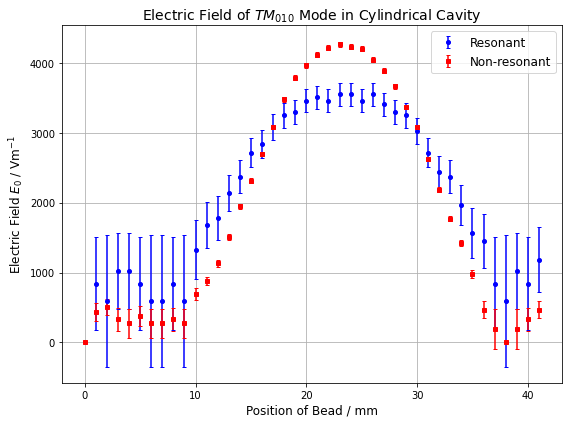

In [20]:
# plot position vs E0 for non-resoant and resonant method

bead_pos = (data[0] - data[0][0]) * 1e-3 # m
delta_omega = data[1] * 1e3  # Hz
delta_rho = data[2]  # dB
bead_pos_err = 0.2 * 1e-3  # m
delta_omega_err = 7 * 1e3 # Hz
delta_rho_err = 0.003   #dB

E0_r = E0_res(delta_omega, res_freq, W)
E0_r_err = E0_res_err(delta_omega, res_freq, W, delta_omega_err, freq_err, W_err)

E0_nr = E0_nonres(delta_rho, kappa, Q0, W)
E0_nr_err = E0_nonres_err(delta_rho, kappa, Q0, W, delta_rho_err, kappa_err, Q0_err, W_err)

fig, ax = plt.subplots(figsize=(8,6), tight_layout=True)
ax.errorbar(bead_pos * 1e3, E0_r, yerr=E0_r_err, label="Resonant", color="b", 
            ls="", marker="o", ms=4.0, capsize=2.0)
ax.errorbar(bead_pos * 1e3, E0_nr, yerr=E0_nr_err, label="Non-resonant", color="r", 
            ls="", marker="s", ms=4.0, capsize=2.0)

ax.set_xlabel("Position of Bead / mm", fontsize=12)
ax.set_ylabel("Electric Field $E_0$ / Vm$^{{-1}}$", fontsize=12)
ax.set_title("Electric Field of $TM_{{010}}$ Mode in Cylindrical Cavity", fontsize=14)

ax.grid()
ax.legend(prop={"size":12})

# print max
print("Max. using resonant method: {0} +- {1}".format(np.max(E0_r), E0_r_err[np.argmax(E0_r)]))
print("Max. using non-resonant method: {0} +- {1}".format(np.max(E0_nr), E0_nr_err[np.argmax(E0_nr)]))

Max. using resonant method: 3457.1844980897063 +- 174.03139102849858
Max. using non-resonant method: 4154.082438051451 +- 98.63215838448124


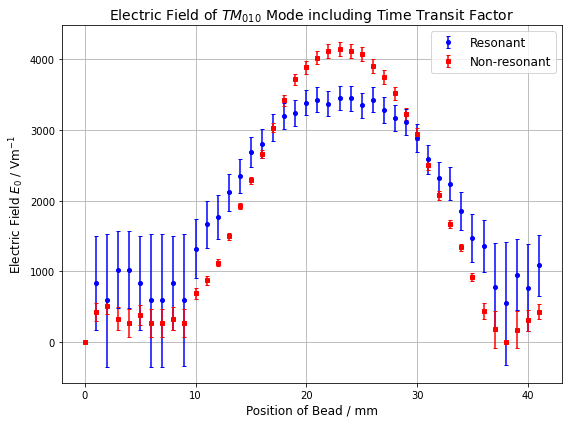

In [21]:
# now consider the transit time factor
c = 3e8  # speed of light

def transit_time_factor(z, res_freq):
    return np.cos(res_freq * z / c)
def transit_time_factor_err(z, zerr, res_freq, res_freq_err):
    return np.sqrt( (np.sin(res_freq * z / c) * z / c * res_freq_err)**2. \
                    + (np.sin(res_freq * z / c) * res_freq / c * zerr))

tt = transit_time_factor(bead_pos, res_freq)
tt_err = transit_time_factor_err(bead_pos, bead_pos_err, res_freq, freq_err)

E0_r_tt = E0_r * tt
E0_r_tt_err = np.sqrt((E0_r * tt_err)**2. + (tt * E0_r_err)**2.)

E0_nr_tt = E0_nr * tt
E0_nr_tt_err = np.sqrt((E0_nr * tt_err)**2. + (tt * E0_nr_err)**2.)

fig, ax = plt.subplots(figsize=(8,6), tight_layout=True)
ax.errorbar(bead_pos * 1e3, E0_r_tt, yerr=E0_r_tt_err, label="Resonant", color="b", 
            ls="", marker="o", ms=4.0, capsize=2.0)
ax.errorbar(bead_pos * 1e3, E0_nr_tt, yerr=E0_nr_tt_err, label="Non-resonant", color="r", 
            ls="", marker="s", ms=4.0, capsize=2.0)

ax.set_xlabel("Position of Bead / mm", fontsize=12)
ax.set_ylabel("Electric Field $E_0$ / Vm$^{{-1}}$", fontsize=12)
ax.set_title("Electric Field of $TM_{{010}}$ Mode including Time Transit Factor", fontsize=14)

ax.grid()
ax.legend(prop={"size":12})

# print max
print("Max. using resonant method: {0} +- {1}".format(np.max(E0_r_tt), E0_r_tt_err[np.argmax(E0_r_tt)]))
print("Max. using non-resonant method: {0} +- {1}".format(np.max(E0_nr_tt), E0_nr_tt_err[np.argmax(E0_nr_tt)]))

## Shunt impedance

- Shift bead position so that it is zero at the center of the cavity
  - for interpolation
- interpolate the electric field 
- using gauss-legendre quadrature to integrate over -L/2 to L/2 
- divide by the power dissipation


max E-field position: res: 23, non-res: 23
Integration error:  6.298170518448387e-08 1.4907178069734073e-07
Shunt impedance using Pv: res: 3.316401611125807 M Ohms +- 0.03403368310048699, non-res: 3.791146672373065 M Ohms +- 0.03890562711167254


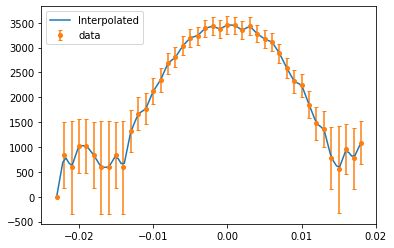

In [22]:
from scipy.interpolate import interp1d
from scipy.integrate import quadrature

# check if max. of electric field is same at both methods
print("max E-field position: res: {0}, non-res: {1}".format(np.argmax(E0_r_tt), np.argmax(E0_nr_tt)))

# since they are the same, use one of the argmax to get shifted bead position
bead_pos_shifted = bead_pos - bead_pos[np.argmax(E0_r_tt)]

# interpolate electric field
E0_r_tt_func = interp1d(bead_pos_shifted, E0_r_tt, fill_value="extrapolate")
E0_nr_tt_func = interp1d(bead_pos_shifted, E0_nr_tt, fill_value="extrapolate")

# check if we get our original plot back
z_test = np.linspace(np.min(bead_pos_shifted), np.max(bead_pos_shifted), 100)
plt.plot(z_test, E0_r_tt_func(z_test), label="Interpolated")
plt.errorbar(bead_pos_shifted, E0_r_tt, yerr=E0_r_tt_err, ls="", marker="o", label="data", ms=4.0, capsize=2.0)
plt.legend()

# evaluate shunt impedance
Lcav = 20 * 1e-3  # m  # length of cavity

intgral_r_tt, intgral_r_tt_err = quadrature(E0_r_tt_func, -Lcav / 2, Lcav / 2, maxiter=1000, tol=1e-8, rtol=1e-8)
intgral_nr_tt, intgral_nr_tt_err = quadrature(E0_nr_tt_func, -Lcav / 2, Lcav / 2, maxiter=1000, tol=1e-8, rtol=1e-8)

print("Integration error: ", intgral_r_tt_err, intgral_nr_tt_err)

Rs_r_tt = intgral_r_tt**2. / Ploss
Rs_nr_tt = intgral_nr_tt**2. / Ploss

# evaluate error
def shunt_impedance_error(Rs, E0, Ploss, res_freq, Ploss_err, res_freq_err, L):
    Ploss_term = Rs / Ploss * Ploss_err

    E0_sin_z_func = lambda z: E0(z) * np.sin(res_freq * z / c) * z / c
    res_freq_term = quadrature(E0_sin_z_func, -L / 2, L / 2, maxiter=1000, tol=1e-8, rtol=1e-8)[0] / Ploss * res_freq_err

    return np.sqrt( Ploss_term**2. + res_freq_term**2.)

Rs_r_tt_err = shunt_impedance_error(Rs_r_tt, E0_r_tt_func, Ploss, res_freq, Ploss_err, freq_err, Lcav)
Rs_nr_tt_err = shunt_impedance_error(Rs_nr_tt, E0_nr_tt_func, Ploss, res_freq, Ploss_err, freq_err, Lcav)

print("Shunt impedance using Pv: res: {0} M Ohms +- {1}, non-res: {2} M Ohms +- {3}".format(Rs_r_tt*1e-6, Rs_r_tt_err*1e-6, Rs_nr_tt*1e-6, Rs_nr_tt_err*1e-6))

max E-field position: res: 23, non-res: 23
Integration error:  1.6266176317003556e-07 5.990106899389502e-07
Shunt impedance using Pv without time transit factor: res: 3.509096037453571 M Ohms +- 0.03601115802959939, non-res: 4.011942285565372 M Ohms +- 0.04117148294293109


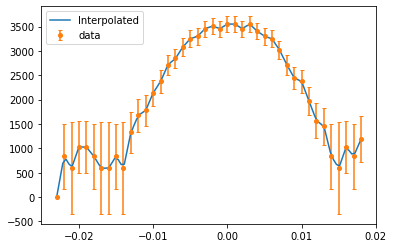

In [23]:
from scipy.interpolate import interp1d
from scipy.integrate import quadrature

# check if max. of electric field is same at both methods
print("max E-field position: res: {0}, non-res: {1}".format(np.argmax(E0_r), np.argmax(E0_nr)))

# since they are the same, use one of the argmax to get shifted bead position
bead_pos_shifted = bead_pos - bead_pos[np.argmax(E0_r)]

# interpolate electric field
E0_r_func = interp1d(bead_pos_shifted, E0_r, fill_value="extrapolate")
E0_nr_func = interp1d(bead_pos_shifted, E0_nr, fill_value="extrapolate")

# check if we get our original plot back
z_test = np.linspace(np.min(bead_pos_shifted), np.max(bead_pos_shifted), 100)
plt.plot(z_test, E0_r_func(z_test), label="Interpolated")
plt.errorbar(bead_pos_shifted, E0_r, yerr=E0_r_err, ls="", marker="o", label="data", ms=4.0, capsize=2.0)
plt.legend()

# evaluate shunt impedance
Lcav = 20 * 1e-3  # m  # length of cavity

intgral_r, intgral_r_err = quadrature(E0_r_func, -Lcav / 2, Lcav / 2, maxiter=1000, tol=1e-8, rtol=1e-8)
intgral_nr, intgral_nr_err = quadrature(E0_nr_func, -Lcav / 2, Lcav / 2, maxiter=1000, tol=1e-8, rtol=1e-8)

print("Integration error: ", intgral_r_err, intgral_nr_err)

Rs_r = intgral_r**2. / Ploss
Rs_nr = intgral_nr**2. / Ploss

# evaluate error
def shunt_impedance_error(Rs, E0, Ploss, res_freq, Ploss_err, res_freq_err, L):
    Ploss_term = Rs / Ploss * Ploss_err

    E0_sin_z_func = lambda z: E0(z) * np.sin(res_freq * z / c) * z / c
    res_freq_term = quadrature(E0_sin_z_func, -Lcav / 2, Lcav / 2, maxiter=1000, tol=1e-8, rtol=1e-8)[0] / Ploss * res_freq_err

    return np.sqrt( Ploss_term**2. + res_freq_term**2.)

Rs_r_err = shunt_impedance_error(Rs_r, E0_r_func, Ploss, res_freq, Ploss_err, freq_err, Lcav)
Rs_nr_err = shunt_impedance_error(Rs_nr, E0_nr_func, Ploss, res_freq, Ploss_err, freq_err, Lcav)

print("Shunt impedance using Pv without time transit factor: res: {0} M Ohms +- {1}, non-res: {2} M Ohms +- {3}".format(Rs_r*1e-6, Rs_r_err*1e-6, Rs_nr*1e-6, Rs_nr_err*1e-6))

In [24]:
# calculate shunt impedance without using power dissipation formula
# to see if its any different as if we use the power disspation formula

# since they are the same, use one of the argmax to get shifted bead position
bead_pos_shifted = bead_pos - bead_pos[np.argmax(E0_r)]

# interpolate electric field
E0_r_func = interp1d(bead_pos_shifted, E0_r, fill_value="extrapolate")
E0_nr_func = interp1d(bead_pos_shifted, E0_nr, fill_value="extrapolate")

E0_r_tt_func = interp1d(bead_pos_shifted, E0_r_tt, fill_value="extrapolate")
E0_nr_tt_func = interp1d(bead_pos_shifted, E0_nr_tt, fill_value="extrapolate")

# also interpolate delta_omega, delta_rho
delta_omega_func = interp1d(bead_pos_shifted, np.sqrt(delta_omega), fill_value="extrapolate")
delta_rho_func = interp1d(bead_pos_shifted, np.sqrt(delta_rho), fill_value="extrapolate")

# evaluate shunt impedance
Lcav = 20 * 1e-3  # m  # length of cavity

delay_coeff_r = np.abs(quadrature(E0_r_tt_func, -Lcav/2, Lcav/2,  maxiter=1000, tol=1e-8, rtol=1e-8)[0] / \
                        quadrature(E0_r_func, -Lcav/2, Lcav/2,  maxiter=1000, tol=1e-8, rtol=1e-8)[0])**2.

delay_coeff_nr = np.abs(quadrature(E0_nr_tt_func, -Lcav/2, Lcav/2,  maxiter=1000, tol=1e-8, rtol=1e-8)[0] / \
                        quadrature(E0_nr_func, -Lcav/2, Lcav/2,  maxiter=1000, tol=1e-8, rtol=1e-8)[0])**2.

delta_omega_int = np.abs(quadrature(delta_omega_func, -Lcav/2, Lcav/2,  maxiter=1000, tol=1e-8, rtol=1e-8)[0])**2.
Rs_r_delay = delay_coeff_r * 2 * Q0 / (res_freq**2. * alpha_s) * delta_omega_int

delta_rho_int = np.abs(quadrature(delta_rho_func, -Lcav/2, Lcav/2,  maxiter=1000, tol=1e-8, rtol=1e-8)[0])**2.
Rs_nr_delay = delay_coeff_nr * (1 + kappa)**2. / (2 * res_freq * kappa * alpha_s) * delta_rho_int

print("Shunt impedance not using Pv: res: {0} MOhms +- {1}, non-res: {2} MOhms +- {3}".format(Rs_r_delay * 1e-6, 0 * 1e-6, Rs_nr_delay * 1e-6, 0))

Shunt impedance not using Pv: res: 3.3164016111258054 MOhms +- 0.0, non-res: 3.7911829788617974 MOhms +- 0


## Energy gain of particle in such cavity

calculate energy gain of particle passing our cavity depending on input power P

- this is obtained by the formula for shunt impedance in an oscillating circuit and the power dissipation formula in relation to coupling coefficient.

In [29]:
def energy_gain(Ploss, Rs, kappa):
    return np.sqrt(2 * Rs * Ploss / (1 + kappa))

def energy_gain_err(Ploss, Rs, kappa, Rs_err, kappa_err):
    Rs_term2 = Ploss / (2 * Rs * (1 + kappa)) * Rs_err**2.
    kappa_term2 = Rs * Ploss / ( (1 + kappa)**3. * 2) * kappa_err**2.

    return np.sqrt(Rs_term2 + kappa_term2)


input_powers = [1e3, 10e3, 100e3, 1000e3]

for Pv in input_powers:
    Egain_r = energy_gain(Pv, Rs_r, kappa)
    Egain_nr = energy_gain(Pv, Rs_nr, kappa)

    Egain_r_err = energy_gain_err(Pv, Rs_r, kappa, Rs_r_err, kappa_err)
    Egain_nr_err = energy_gain_err(Pv, Rs_nr, kappa, Rs_nr_err, kappa_err)

    # print results
    print("Energy gain with input power of P = {0} kW: res: {1} keV +- {2}, non-res: {3} keV +- {4}".format(Pv*1e-3, Egain_r*1e-3, Egain_r_err*1e-3, Egain_nr*1e-3, Egain_nr_err*1e-3))

Energy gain with input power of P = 1.0 kW: res: 56.51644875923986 keV +- 0.28999342487219787, non-res: 60.430275779123015 keV +- 0.3100757925150817
Energy gain with input power of P = 10.0 kW: res: 178.72070334339512 keV +- 0.9170397290690684, non-res: 191.09731109413502 keV +- 0.9805457516294485
Energy gain with input power of P = 100.0 kW: res: 565.1644875923987 keV +- 2.899934248721978, non-res: 604.3027577912301 keV +- 3.1007579251508175
Energy gain with input power of P = 1000.0 kW: res: 1787.2070334339512 keV +- 9.170397290690683, non-res: 1910.9731109413501 keV +- 9.805457516294485
